# Example: Multiport atom interferometer

In [19]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import aisim as ais

In [88]:
pos_params = {
    'mean_x': 0.0,
    'std_x': 3.0e-3,  # cloud radius in m
    'mean_y': 0.0,
    'std_y': 3.0e-3,  # cloud radius in m
    'mean_z': 0.0,
    'std_z': 0,        # ignore z dimension, its not relevant here
}
vel_params = {
    'mean_vx': 0.0,
    # cloud velocity spread in m/s at tempearture of 3 uK
    'std_vx': ais.convert.vel_from_temp(3.0e-6),
    'mean_vy': 0.0,
    # cloud velocity spread in m/s at tempearture of 3 uK
    'std_vy': ais.convert.vel_from_temp(3.0e-6),
    'mean_vz': 0.0,
    'std_vz': ais.convert.vel_from_temp(80e-9),
}

t_det = 778e-3 # time of the detection in s
r_det = 5e-3 # size of detected region in x-y plane
det = ais.Detector(r_det, t_det) # set detection region

center_Rabi_freq = 2 * np.pi * 12.5e3
r_beam = 29.5e3 / 2  # 1/e^2 beam radius in m
intensity_profile = ais.IntensityProfile(r_beam, center_Rabi_freq)
wave_vectors = ais.Wavevectors(k1=8.052945514e6, k2=-8.052802263e6)

# length of a pi/2 pulse
tau = 1 / 12.5e3 / 4

In [89]:
population0 = []
population1 = []
population2 = []
for phase in np.linspace(0, 2*np.pi, 36):
    
    atoms = ais.create_random_ensemble_from_gaussian_distribution(
    pos_params, vel_params, int(1e4), state_kets=[1, 0, 0, 0, 0, 0], seed=1)
    atoms = det.detected_atoms(atoms)
    
    beam_splitter1 = ais.SpatialSuperpositionTransitionPropagator(
        tau, n_pulse=1, n_pulses=3,
        intensity_profile=intensity_profile, wave_vectors=wave_vectors)
    mirror = ais.SpatialSuperpositionTransitionPropagator(
        2 * tau, n_pulse=2, n_pulses=3,
        intensity_profile=intensity_profile, wave_vectors=wave_vectors)
    beam_splitter2 = ais.SpatialSuperpositionTransitionPropagator(
        tau, n_pulse=3, n_pulses=3,
        intensity_profile=intensity_profile, wave_vectors=wave_vectors,
        phase_scan=phase)
    free_prop= ais.FreePropagator(260e-3)

    atoms = beam_splitter1.propagate(atoms)
    atoms = free_prop.propagate(atoms)
    atoms = mirror.propagate(atoms)
    atoms = free_prop.propagate(atoms)
    atoms = beam_splitter2.propagate(atoms)
    
    population0.append(np.mean(atoms.state_occupation(5)))
    population1.append(np.mean(atoms.state_occupation(2)))
    population2.append(np.mean(atoms.state_occupation(3)))

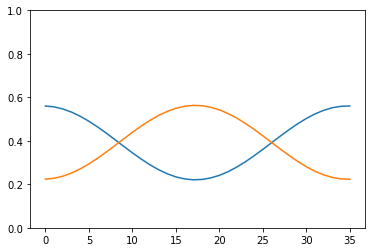

In [90]:
fig, ax = plt.subplots()
ax.set_ylim(0, 1)
plt.plot(population1)
plt.plot(population2)

In [80]:
[np.mean(atoms.state_occupation(i)) for i in range(6)]

[0.007488656417458653,
 0.007195230738240697,
 0.9087753693248608,
 0.06242517954398323,
 0.006920333237217693,
 0.0071952307382389825]

array([0.        , 0.17951958, 0.35903916, 0.53855874, 0.71807832,
       0.8975979 , 1.07711748, 1.25663706, 1.43615664, 1.61567622,
       1.7951958 , 1.97471538, 2.15423496, 2.33375454, 2.51327412,
       2.6927937 , 2.87231328, 3.05183286, 3.23135244, 3.41087202,
       3.5903916 , 3.76991118, 3.94943076, 4.12895034, 4.30846992,
       4.48798951, 4.66750909, 4.84702867, 5.02654825, 5.20606783,
       5.38558741, 5.56510699, 5.74462657, 5.92414615, 6.10366573,
       6.28318531])